# Deep Residual Learning for Image Recognition

This notebook showcases the use of deep residual networks (ResNet) for image classification.

### References

1. K. He, X. Zhang, S. Ren, and J. Sun, “Deep Residual Learning for Image Recognition,” arXiv:1512.03385 [cs], Dec. 2015, Available: http://arxiv.org/abs/1512.03385;

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms.v2 as transforms

In [24]:
from typing import Optional

## Image Processing

We will use a simple baseline dataset, namely CIFAR-10, available in the [torchvision](https://pytorch.org/vision/stable/index.html) package. We start by downloading it and performing some basic preprocessing.

In [25]:
batch_size = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
transform = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4), # first adds 4px padding to each side of the image, then takes a 32x32 crop
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # original images have values in [0, 1], this normalizes them to [-1, 1]
])

train_data = torchvision.datasets.CIFAR10(root="./assets/data/cifar-10", train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)

test_data = torchvision.datasets.CIFAR10(root="./assets/data/cifar-10", train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)

Files already downloaded and verified


The applied data augmentation performs a random flip as well as cropping of an image with added padding. To get a sense of the dataset, we visualize a few of its samples samples.

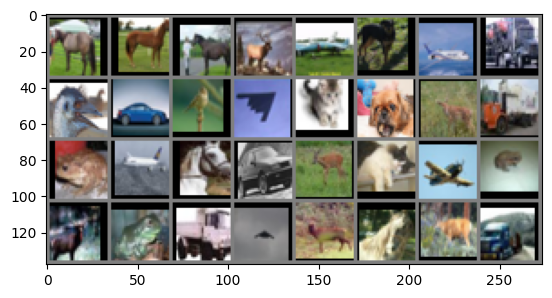

In [5]:
img = next(iter(train_loader))[0][:32] # get a random batch of images
img = torchvision.utils.make_grid(img)
img = img * 0.5 + 0.5 # remove normalization
plt.imshow(img.permute(1, 2, 0));

## Utilities

In this section, we write few boilerplate functions for training and evaluation of our models. This will make the rest of the notebook easier to read, and allow us to experiment with different models, without duplicating the train/eval logic.

In [27]:
loss_fn = nn.CrossEntropyLoss()

In [28]:
def epoch_train(model: nn.Module, loader: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer):
    losses, acc_corr, acc_total = [], 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc_total += y.size(0)
        acc_corr += (y_pred.argmax(dim=1) == y).float().sum().item()
        losses.append(loss.item())

    return np.mean(losses), acc_corr / acc_total

In [29]:
@torch.no_grad()
def epoch_evaluate(model: nn.Module, loader: torch.utils.data.DataLoader):
    loss, acc_corr, acc_total = [], 0, 0
    
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        acc_corr += (y_pred.argmax(dim=1) == y).float().sum().item()
        acc_total += y.size(0)
        loss.append(loss_fn(y_pred, y).item())

    return np.mean(loss), acc_corr / acc_total

In [30]:
def train(model: nn.Module, optimizer: torch.optim.Optimizer, train_loader: torch.utils.data.DataLoader, test_loader: torch.utils.data.DataLoader, epochs: int = 100, scheduler: Optional[torch.optim.lr_scheduler.LRScheduler] = None):
    train_loss, test_loss = [], []
    train_acc, test_acc = [], []
    
    for epoch in range(1, epochs + 1):
        train_loss_epoch, train_acc_epoch = epoch_train(model, train_loader, optimizer)
        test_loss_epoch, test_acc_epoch = epoch_evaluate(model, test_loader)
        train_loss.append(train_loss_epoch); test_loss.append(test_loss_epoch)
        train_acc.append(train_acc_epoch); test_acc.append(test_acc_epoch)
        if epoch % 5 == 0:
            print(f"epoch {epoch}; loss: {train_loss_epoch:.3f}; acc: {train_acc_epoch:.2f}; test_loss: {test_loss_epoch:.3f}; test_acc: {test_acc_epoch:.2f}")
        if scheduler:
            scheduler.step()

    return train_loss, test_loss, train_acc, test_acc

## Baseline

Our baseline is a simple convolutional neural network (CNN) classifier, as used in the [official torch tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). Note that we are not trying to squeeze every bit of performance out of this approach by e.g. playing with the network size or tweaking the optimization procedure, but rather just implement a simple model to obtain an initial set of results indicating what one might expect using a very rudimentary approach.

In [34]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x)) # Bx3x32x32 -> Bx6x28x28
        x = self.pool1(x)         # Bx6x28x28 -> Bx6x14x14

        x = F.relu(self.conv2(x)) # Bx6x14x14 -> Bx16x10x10
        x = self.pool2(x)         # Bx16x10x10 -> Bx16x5x5

        x = torch.flatten(x, 1)   # Bx16x5x5 -> Bx400
        x = F.relu(self.fc1(x))   # Bx400 -> Bx120
        x = F.relu(self.fc2(x))   # Bx120 -> Bx64

        return self.fc3(x)        # Bx64 -> Bx10

In [35]:
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
train_loss, test_loss, train_acc, test_acc = train(model=model, optimizer=optimizer, train_loader=train_loader, test_loader=test_loader, epochs=100)

epoch 5; loss: 2.290; acc: 0.17; test_loss: 2.283; test_acc: 0.18
epoch 10; loss: 2.043; acc: 0.24; test_loss: 2.011; test_acc: 0.26
epoch 15; loss: 1.850; acc: 0.32; test_loss: 1.815; test_acc: 0.33
epoch 20; loss: 1.728; acc: 0.36; test_loss: 1.709; test_acc: 0.36
epoch 25; loss: 1.659; acc: 0.39; test_loss: 1.635; test_acc: 0.40
epoch 30; loss: 1.595; acc: 0.42; test_loss: 1.565; test_acc: 0.43
epoch 35; loss: 1.526; acc: 0.45; test_loss: 1.509; test_acc: 0.45
epoch 40; loss: 1.483; acc: 0.46; test_loss: 1.471; test_acc: 0.47
epoch 45; loss: 1.453; acc: 0.47; test_loss: 1.436; test_acc: 0.49
epoch 50; loss: 1.424; acc: 0.49; test_loss: 1.418; test_acc: 0.49
epoch 55; loss: 1.385; acc: 0.50; test_loss: 1.365; test_acc: 0.51
epoch 60; loss: 1.351; acc: 0.52; test_loss: 1.339; test_acc: 0.52
epoch 65; loss: 1.327; acc: 0.53; test_loss: 1.315; test_acc: 0.53
epoch 70; loss: 1.295; acc: 0.54; test_loss: 1.299; test_acc: 0.53
epoch 75; loss: 1.275; acc: 0.54; test_loss: 1.283; test_acc: 0

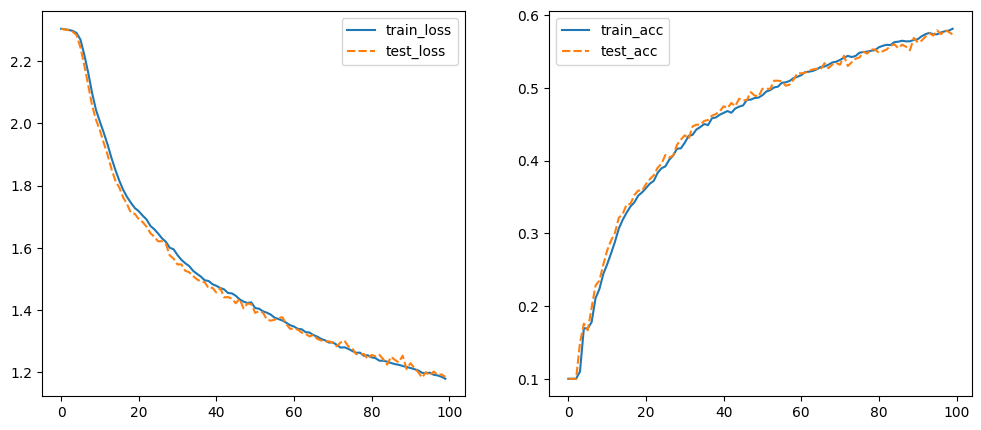

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
data = pd.DataFrame({"train_loss": train_loss, "test_loss": test_loss, "train_acc": train_acc, "test_acc": test_acc})
_ = sns.lineplot(data=data[["train_loss", "test_loss"]], ax=ax[0])
_ = sns.lineplot(data=data[["train_acc", "test_acc"]], ax=ax[1])

The obtained results represent a significant improvement compared to a random classifier. Looking at the train/test curves, we see that the model is not overfitting yet, so a better result should be obtainable by training for some more epochs. Nevertheless, for the time being we will keep our baseline results after $100$ epochs.

## ResNet Implementation

In this section, we will implement and train a residual network (ResNet) model [1] using the same CIFAR-10 dataset. The model used below represents an 18-layer ResNet network (ResNet18). With a simple learning rate scheduler, the model achieves $91\%$ test accuracy.

In [31]:
from microai.models.resnet import ResNet, conv3x3

In [32]:
model = ResNet(num_classes=10, groups=[2, 2, 2, 2], init_filters=64, preprocess=conv3x3(3, 64)).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25, 50, 75], gamma=0.1)
train_loss, test_loss, train_acc, test_acc = train(model=model, optimizer=optimizer, train_loader=train_loader, test_loader=test_loader, scheduler=scheduler, epochs=100)

epoch 5; loss: 1.053; acc: 0.62; test_loss: 1.023; test_acc: 0.63
epoch 10; loss: 0.647; acc: 0.78; test_loss: 0.752; test_acc: 0.75
epoch 15; loss: 0.501; acc: 0.83; test_loss: 0.569; test_acc: 0.80
epoch 20; loss: 0.416; acc: 0.86; test_loss: 0.538; test_acc: 0.82
epoch 25; loss: 0.378; acc: 0.87; test_loss: 0.445; test_acc: 0.85
epoch 30; loss: 0.163; acc: 0.94; test_loss: 0.317; test_acc: 0.90
epoch 35; loss: 0.130; acc: 0.95; test_loss: 0.328; test_acc: 0.90
epoch 40; loss: 0.109; acc: 0.96; test_loss: 0.336; test_acc: 0.90
epoch 45; loss: 0.094; acc: 0.97; test_loss: 0.347; test_acc: 0.90
epoch 50; loss: 0.081; acc: 0.97; test_loss: 0.350; test_acc: 0.90
epoch 55; loss: 0.045; acc: 0.98; test_loss: 0.370; test_acc: 0.91
epoch 60; loss: 0.041; acc: 0.99; test_loss: 0.389; test_acc: 0.91
epoch 65; loss: 0.039; acc: 0.99; test_loss: 0.396; test_acc: 0.91
epoch 70; loss: 0.035; acc: 0.99; test_loss: 0.410; test_acc: 0.91
epoch 75; loss: 0.034; acc: 0.99; test_loss: 0.420; test_acc: 0

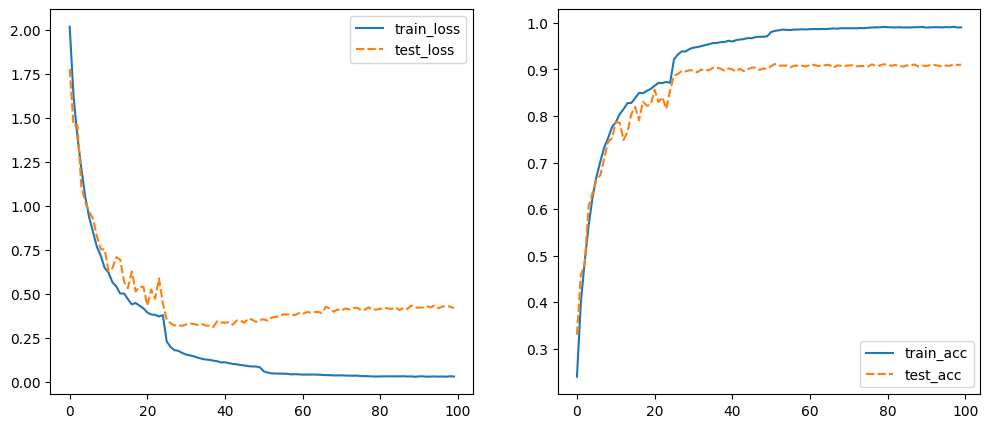

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
data = pd.DataFrame({"train_loss": train_loss, "test_loss": test_loss, "train_acc": train_acc, "test_acc": test_acc})
_ = sns.lineplot(data=data[["train_loss", "test_loss"]], ax=ax[0])
_ = sns.lineplot(data=data[["train_acc", "test_acc"]], ax=ax[1])